In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
#from sklearn_pandas import DataFrameMapper
from collections import defaultdict

## Data Wrangling

In [3]:
user = pd.read_csv('takehome_users.csv', encoding='latin-1')
userEngagement = pd.read_csv('takehome_user_engagement.csv',
                             index_col='time_stamp')

In [4]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
user = user.reindex(user.object_id).drop('object_id',axis=1)

In [6]:
user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0.0,0.0,1.0,316.0
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0.0,0.0,94.0,1525.0
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0.0,0.0,1.0,5151.0
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0.0,0.0,193.0,5240.0
5,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0.0,0.0,197.0,11241.0


In [7]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 11999 non-null object
name                          11999 non-null object
email                         11999 non-null object
creation_source               11999 non-null object
last_session_creation_time    8822 non-null float64
opted_in_to_mailing_list      11999 non-null float64
enabled_for_marketing_drip    11999 non-null float64
org_id                        11999 non-null float64
invited_by_user_id            6416 non-null float64
dtypes: float64(5), object(4)
memory usage: 937.5+ KB


In [8]:
user.isnull().sum()

creation_time                    1
name                             1
email                            1
creation_source                  1
last_session_creation_time    3178
opted_in_to_mailing_list         1
enabled_for_marketing_drip       1
org_id                           1
invited_by_user_id            5584
dtype: int64

Number of missing values for Users.

In [9]:
userEngagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


User Engagements made clear with 1s for each time.

In [10]:
userEngagement.info()
#type(userEngagement.index[12]) string, object type

<class 'pandas.core.frame.DataFrame'>
Index: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8+ MB


No missing values for Engagement Data

Let us change the time_stamp index column from object to datetime

In [11]:
userEngagement.index= pd.to_datetime(userEngagement.index)

In [12]:
userEngagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [13]:
userEngagement.user_id.nunique() 

8823

In [14]:
weekly_loginFin = userEngagement.groupby('user_id')['visited'].rolling('7D').count()
#weekly_loginFin
adopted_user = weekly_loginFin.groupby('user_id').max() >= 3

adopted_user[:20]

user_id
1     False
2      True
3     False
4     False
5     False
6     False
7     False
10     True
11    False
13    False
14    False
17    False
19    False
20     True
21    False
22    False
23    False
24    False
25    False
27    False
Name: visited, dtype: bool

### Most important part :

I am trying to define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period. Groupby each user first, then Rolling ('7D') collects the data for a 7 day period, rolling it each day, and max > 3 will give us the three seperate logins in a week for each individual user. 

In [15]:
users = user.join(adopted_user)
users.head(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
object_id,,,,,,,,,,
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0.0,0.0,1.0,316.0,False
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0.0,0.0,94.0,1525.0,True
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0.0,0.0,1.0,5151.0,False
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0.0,0.0,193.0,5240.0,False
5,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0.0,0.0,197.0,11241.0,False
6,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0.0,1.0,37.0,NaN,False
7,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1.0,1.0,74.0,NaN,False
8,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0.0,0.0,302.0,NaN,NaN
9,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1.0,1.0,318.0,4143.0,NaN


Joining both dataframes.

In [16]:
users.visited.fillna(False,inplace=True)
users.tail(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
object_id,,,,,,,,,,
11991,2014-04-09 19:39:56,Hermansen Amanda,AmandaAHermansen@yahoo.com,PERSONAL_PROJECTS,1.397245e+09,0.0,0.0,129.0,NaN,False
11992,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0.0,0.0,281.0,NaN,False
11993,2012-06-05 04:46:16,Grimstone Joel,conxzghp@eaouk.com,GUEST_INVITE,NaN,0.0,0.0,84.0,5450.0,False
11994,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,1.382449e+09,0.0,0.0,0.0,NaN,False
11995,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0.0,0.0,89.0,8263.0,False
11996,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0.0,0.0,200.0,NaN,False
11997,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1.0,1.0,83.0,8074.0,False
11998,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0.0,0.0,6.0,NaN,False
11999,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0.0,1.0,0.0,NaN,False


In [17]:
users.isnull().sum()

creation_time                    1
name                             1
email                            1
creation_source                  1
last_session_creation_time    3178
opted_in_to_mailing_list         1
enabled_for_marketing_drip       1
org_id                           1
invited_by_user_id            5584
visited                          0
dtype: int64

In [18]:
users.invited_by_user_id.fillna(0,inplace=True)
user.head(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0.0,0.0,1.0,316.0
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0.0,0.0,94.0,1525.0
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0.0,0.0,1.0,5151.0
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0.0,0.0,193.0,5240.0
5,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0.0,0.0,197.0,11241.0
6,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0.0,1.0,37.0,NaN
7,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1.0,1.0,74.0,NaN
8,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0.0,0.0,302.0,NaN
9,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1.0,1.0,318.0,4143.0


In [19]:
users = users.drop(users.index[11999])
users.tail()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
object_id,,,,,,,,,,
11995,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0.0,0.0,89.0,8263.0,False
11996,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0.0,0.0,200.0,0.0,False
11997,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1.0,1.0,83.0,8074.0,False
11998,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0.0,0.0,6.0,0.0,False
11999,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0.0,1.0,0.0,0.0,False


In [20]:
users.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
visited                          0
dtype: int64

In [21]:
Enc = LabelEncoder()
users['creation_source_LblEnc'] = Enc.fit_transform(users.creation_source)

users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,creation_source_LblEnc
object_id,,,,,,,,,,,
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0.0,0.0,1.0,316.0,False,1
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0.0,0.0,94.0,1525.0,True,1
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0.0,0.0,1.0,5151.0,False,0
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0.0,0.0,193.0,5240.0,False,0
5,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0.0,0.0,197.0,11241.0,False,0


In [22]:

users["creation_source"] = users["creation_source"].astype('category')
users['creation_source_cat'] = users['creation_source'].cat.codes
users.dtypes
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,creation_source_LblEnc,creation_source_cat
object_id,,,,,,,,,,,,
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0.0,0.0,1.0,316.0,False,1,1
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0.0,0.0,94.0,1525.0,True,1,1
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0.0,0.0,1.0,5151.0,False,0,0
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0.0,0.0,193.0,5240.0,False,0,0
5,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0.0,0.0,197.0,11241.0,False,0,0


## Replacing the categorical values into numeric ones

Label encoding and 'cat.codes' function convert the categorical data into numeric

In [23]:
random_state = 8
x_train, x_test, y_train, y_test = train_test_split(users[['creation_source_cat','org_id','opted_in_to_mailing_list','enabled_for_marketing_drip']], 
                                                    users['visited'], test_size=0.2, random_state=random_state)

### Divide the data into train and test sets

In [24]:
model = RandomForestClassifier(random_state=random_state)
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, pred)))

Accuracy: 0.8150
Precision: 0.1149
Recall: 0.0515


### Model Accucay, Precision and Recall scores with Random Forest Classifier

Data is imbalanced. We need to implement sampling on the data. I will use imblearn module of python

In [26]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=random_state)
x_res, y_res = cc.fit_sample(users[['creation_source_cat','org_id','opted_in_to_mailing_list','enabled_for_marketing_drip']], 
                                                    users['visited'])
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=random_state)

### Conducted under sampling with imblearn module

In [27]:
model = RandomForestClassifier(random_state=random_state)
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, pred)))

Accuracy: 0.7473
Precision: 0.7522
Recall: 0.7658


### Similar modeling with under sampled data. Accuracy, precision and recall are almost the same.

In [28]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(visible=False)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%d\n%.2f%%' % (cm[i, j], cm_norm[i, j]*100),
                 horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

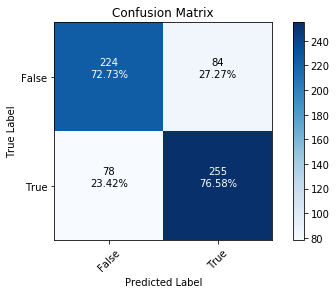

In [29]:
import itertools

plot_confusion_matrix(confusion_matrix(y_test, pred), ['False', 'True'])


### Visualization of the Data (Confusion Matrix)